<a href="https://colab.research.google.com/github/elenadigrigoli/FDS-project/blob/leb/LEB_FINALE_SAME_PREPROCESS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!git clone https://github.com/elenadigrigoli/FDS-project.git

fatal: destination path 'FDS-project' already exists and is not an empty directory.


In [31]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os
# Percorsi del dataset
train_path = '/content/FDS-project/final dataset/train'
test_path = '/content/FDS-project/final dataset/test'

# Trasformazioni per preprocessing e data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(1)),

])

# Caricamento del training set e test set
train_dataset_full = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

class_names = train_dataset_full.classes

# Calcolo delle dimensioni
train_size = int(0.85 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size

# Suddivisione
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

# Creazione dei DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Controllo delle classi
print(f"Classi nel dataset: {class_names}")


Classi nel dataset: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


Training Set:


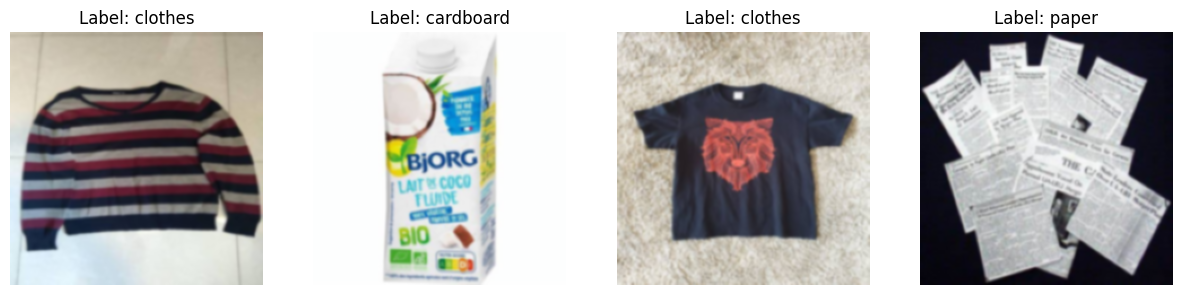

Validation Set:


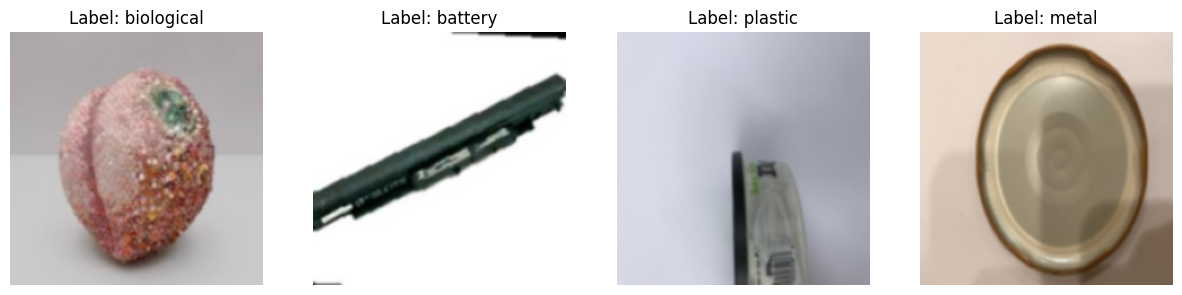

Test Set:


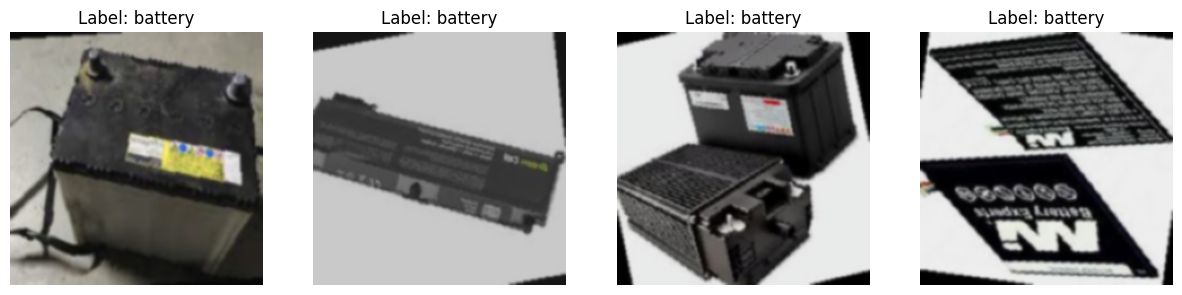

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Funzione per de-normalizzare le immagini
def denormalize_image(tensor, mean, std):
    tensor = tensor.clone()  # Crea una copia per evitare modifiche all'originale
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Operazione inversa della normalizzazione
    return tensor

# Funzione per visualizzare un batch di immagini
def show_images_from_loader(loader, parent_dataset, mean, std):
    """
    Visualizza un batch di immagini preprocessate con le relative etichette.

    Args:
        loader (DataLoader): Il DataLoader da cui estrarre un batch.
        parent_dataset (Dataset): Il dataset padre (ad es. train_dataset_full).
        mean (list): Media utilizzata per la normalizzazione.
        std (list): Deviazione standard utilizzata per la normalizzazione.
    """
    classes = parent_dataset.classes  # Ottieni le classi dal dataset padre
    data_iter = iter(loader)
    images, labels = next(data_iter)  # Preleva un batch

    # De-normalizza il batch
    images = images.clone()
    for i in range(images.size(0)):
        images[i] = denormalize_image(images[i], mean, std)

    # Converti in formato numpy per matplotlib
    images = images.numpy().transpose((0, 2, 3, 1))  # Da CxHxW a HxWxC

    # Visualizza le prime 4 immagini del batch
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axes):
        if i >= len(images):  # Evita errori se ci sono meno di 4 immagini nel batch
            break
        ax.imshow(np.clip(images[i], 0, 1))  # Assicura che i valori siano nel range [0, 1]
        ax.axis("off")
        ax.set_title(f"Label: {classes[labels[i]]}")
    plt.show()

# Parametri per la normalizzazione (standard ImageNet)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Visualizza un batch dal training set
print("Training Set:")
show_images_from_loader(train_loader, train_dataset_full, mean, std)

# Visualizza un batch dal validation set
print("Validation Set:")
show_images_from_loader(val_loader, train_dataset_full, mean, std)

# Visualizza un batch dal test set
print("Test Set:")
show_images_from_loader(test_loader, test_dataset, mean, std)



In [33]:
import torch
import torch.nn as nn
from torchvision import models

#V erifica se la GPU è disponibile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Caricamento del modello preaddestrato EfficientNet-B0
model = models.efficientnet_b0(pretrained=True)

# Modifica del layer finale per 10 classi
num_classes = 10
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Sposta il modello su GPU (se disponibile)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
import torch.optim as optim

# Funzione di perdita e ottimizzatore
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Ciclo di addestramento
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

    # Validazione
    model.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            correct += (outputs.argmax(1) == labels).sum().item()

    print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {correct / len(val_dataset):.4f}")


Epoch 1/10, Loss: 0.4889
Validation Loss: 0.2612, Accuracy: 0.9156
Epoch 2/10, Loss: 0.2563
Validation Loss: 0.2290, Accuracy: 0.9290
Epoch 3/10, Loss: 0.1980
Validation Loss: 0.2313, Accuracy: 0.9321
Epoch 4/10, Loss: 0.1496
Validation Loss: 0.1823, Accuracy: 0.9459
Epoch 5/10, Loss: 0.1333
Validation Loss: 0.2072, Accuracy: 0.9482
Epoch 6/10, Loss: 0.1074
Validation Loss: 0.1765, Accuracy: 0.9497
Epoch 7/10, Loss: 0.1013
Validation Loss: 0.2206, Accuracy: 0.9340
Epoch 8/10, Loss: 0.1105
Validation Loss: 0.2231, Accuracy: 0.9290
Epoch 9/10, Loss: 0.0686
Validation Loss: 0.3021, Accuracy: 0.9259
Epoch 10/10, Loss: 0.0854
Validation Loss: 0.2233, Accuracy: 0.9394


In [35]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Test del modello con raccolta di predizioni e etichette vere
model.eval()
test_loss, correct = 0.0, 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_loss += criterion(outputs, labels).item()
        predictions = outputs.argmax(1)
        correct += (predictions == labels).sum().item()

        # Salva predizioni e etichette vere
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# Stampa dei risultati principali
accuracy = correct / len(test_dataset)
print(f"Test Loss: {test_loss / len(test_loader):.4f}, Accuracy: {accuracy:.4f}")

# Classificazione dettagliata
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_names))

Test Loss: 0.2228, Accuracy: 0.9415

Classification Report:
              precision    recall  f1-score   support

     battery       0.93      0.97      0.95       300
  biological       0.97      0.95      0.96       300
   cardboard       0.95      0.95      0.95       362
     clothes       1.00      0.98      0.99      1065
       glass       0.92      0.92      0.92       608
       metal       0.85      0.93      0.89       300
       paper       0.95      0.92      0.94       330
     plastic       0.95      0.84      0.89       383
       shoes       0.91      0.97      0.94       396
       trash       0.91      0.93      0.92       300

    accuracy                           0.94      4344
   macro avg       0.93      0.94      0.93      4344
weighted avg       0.94      0.94      0.94      4344



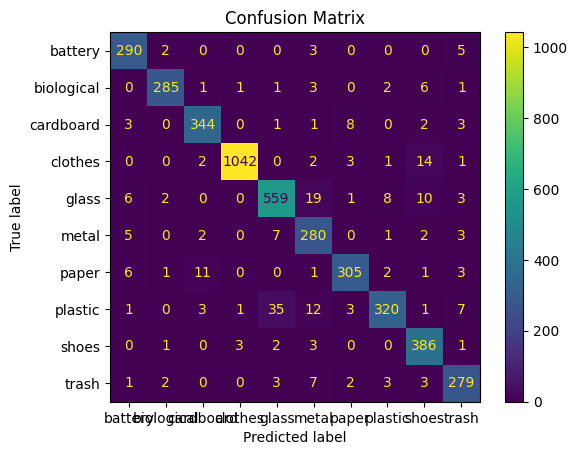

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Matrice di confusione
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis')
plt.title("Confusion Matrix")
plt.show()

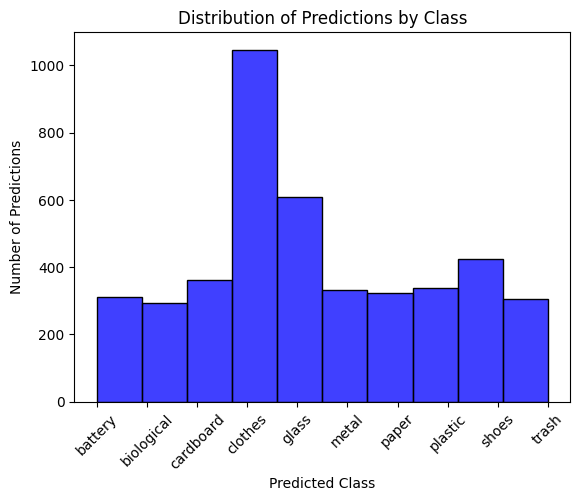

In [37]:
import seaborn as sns

# Grafico della distribuzione delle predizioni
sns.histplot(all_predictions, bins=len(class_names), kde=False, color="blue")
plt.xlabel('Predicted Class')
plt.ylabel('Number of Predictions')
plt.title('Distribution of Predictions by Class')
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.show()

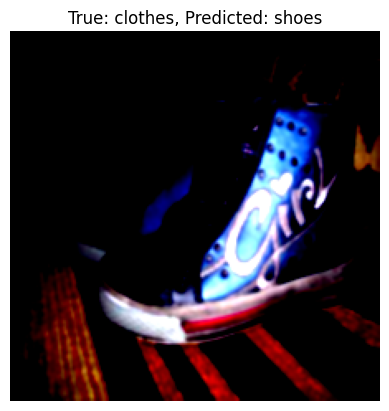

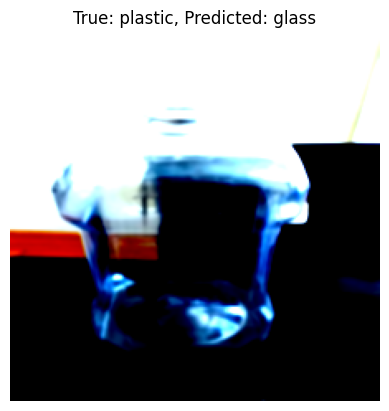

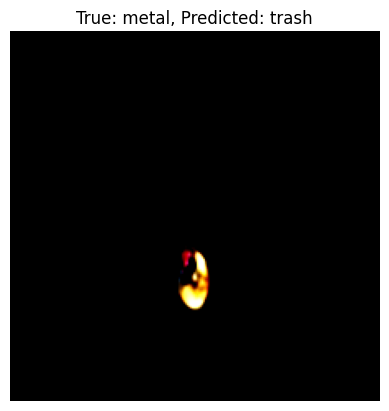

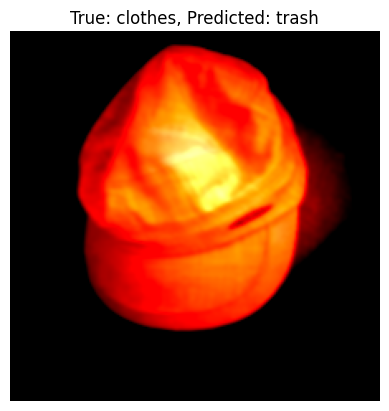

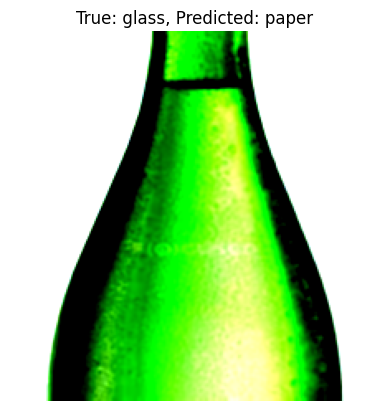

In [38]:
import numpy as np

# Itera per visualizzare le immagini mal classificate
wrong_predictions = []
for i in range(len(all_labels)):
    if all_labels[i] != all_predictions[i]:
        wrong_predictions.append(i)

# Mostra un campione di immagini mal classificate
wrong_samples = np.random.choice(wrong_predictions, min(5, len(wrong_predictions)), replace=False)

for idx in wrong_samples:
    image, true_label, pred_label = test_loader.dataset[idx][0], all_labels[idx], all_predictions[idx]
    plt.imshow(image.permute(1, 2, 0))  # Converte il tensore in immagine
    plt.title(f"True: {class_names[true_label]}, Predicted: {class_names[pred_label]}")
    plt.axis("off")
    plt.show()

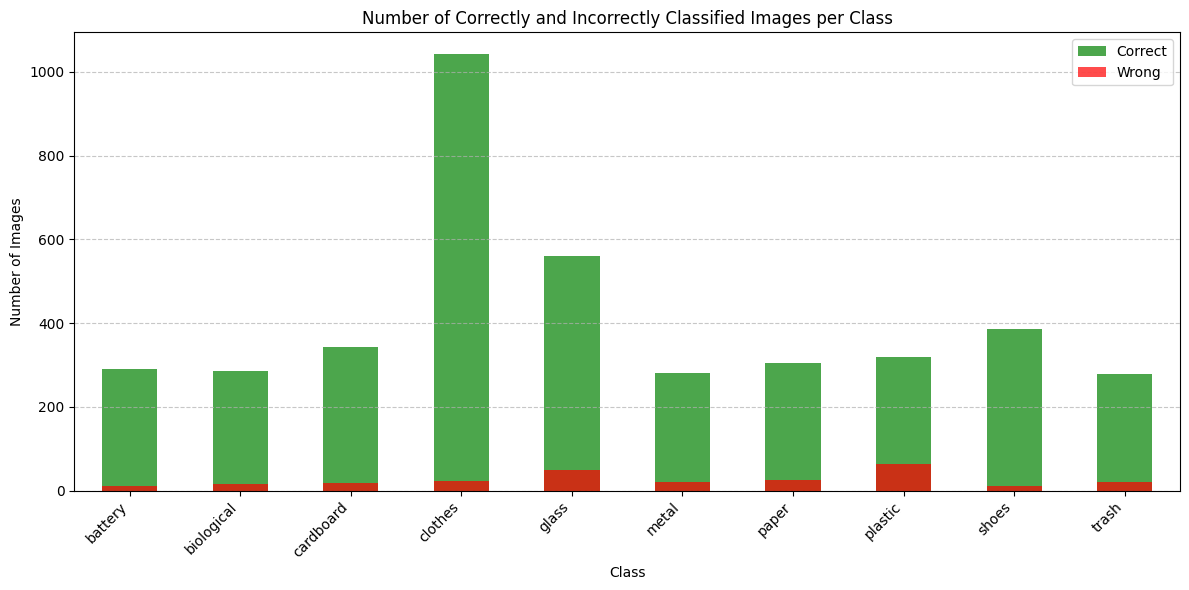

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Supponiamo di avere all_labels (etichette vere) e all_predictions (predizioni del modello)
# E class_names contiene i nomi delle classi

# Conta immagini totali per classe
all_labels = np.array(all_labels)  # Converti in array per calcoli più semplici
all_predictions = np.array(all_predictions)

# Conta immagini classificate correttamente
correct_indices = all_labels == all_predictions
correct_labels = all_labels[correct_indices]
correct_counts = pd.Series(correct_labels).value_counts().reindex(range(len(class_names)), fill_value=0)

# Conta immagini classificate male
wrong_indices = all_labels != all_predictions
wrong_labels = all_labels[wrong_indices]
wrong_counts = pd.Series(wrong_labels).value_counts().reindex(range(len(class_names)), fill_value=0)

# Converte in DataFrame con nomi delle classi
distribution = pd.DataFrame({
    'Correct': correct_counts,
    'Wrong': wrong_counts
})
distribution.index = class_names

# Plot degli istogrammi sovrapposti
plt.figure(figsize=(12, 6))
distribution['Correct'].plot(kind='bar', color='green', alpha=0.7, label='Correct')
distribution['Wrong'].plot(kind='bar', color='red', alpha=0.7, label='Wrong')
plt.title('Number of Correctly and Incorrectly Classified Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

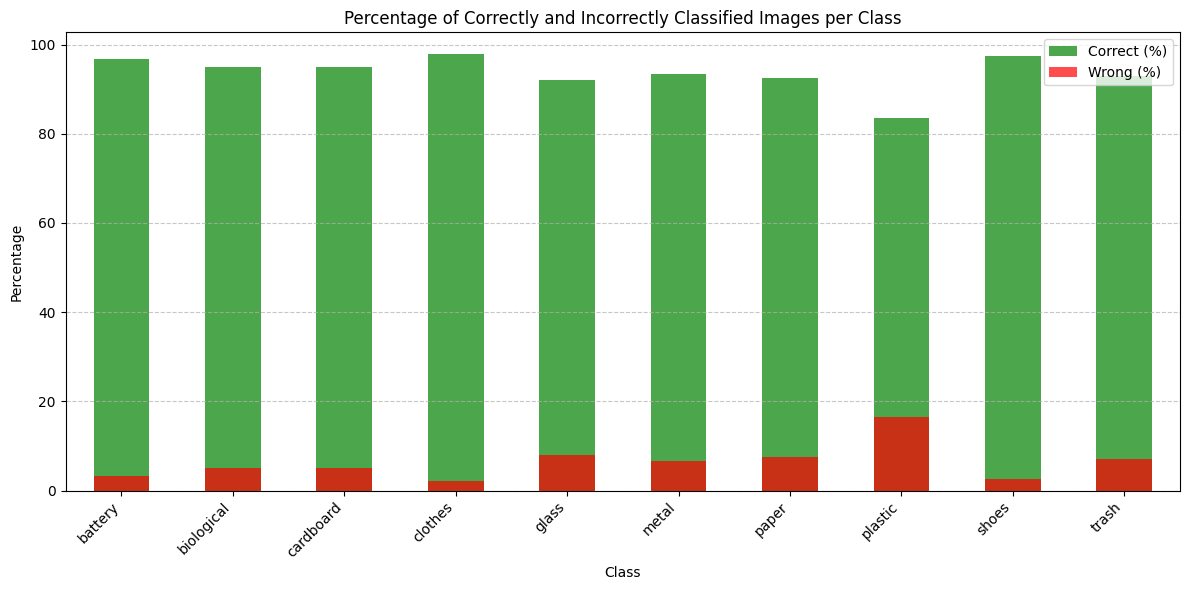

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Supponiamo di avere all_labels (etichette vere) e all_predictions (predizioni del modello)
# E class_names contiene i nomi delle classi

# Conta immagini totali per classe
all_labels = np.array(all_labels)  # Converti in array per calcoli più semplici
all_predictions = np.array(all_predictions)

total_counts = pd.Series(all_labels).value_counts().reindex(range(len(class_names)), fill_value=0)

# Conta immagini classificate correttamente
correct_indices = all_labels == all_predictions
correct_labels = all_labels[correct_indices]
correct_counts = pd.Series(correct_labels).value_counts().reindex(range(len(class_names)), fill_value=0)

# Conta immagini classificate male
wrong_counts = total_counts - correct_counts

# Calcola percentuali
correct_percentages = (correct_counts / total_counts) * 100
wrong_percentages = (wrong_counts / total_counts) * 100

# Converte in DataFrame con nomi delle classi
distribution = pd.DataFrame({
    'Correct (%)': correct_percentages,
    'Wrong (%)': wrong_percentages
})
distribution.index = class_names

# Plot degli istogrammi sovrapposti
plt.figure(figsize=(12, 6))
distribution['Correct (%)'].plot(kind='bar', color='green', alpha=0.7, label='Correct (%)')
distribution['Wrong (%)'].plot(kind='bar', color='red', alpha=0.7, label='Wrong (%)')
plt.title('Percentage of Correctly and Incorrectly Classified Images per Class')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


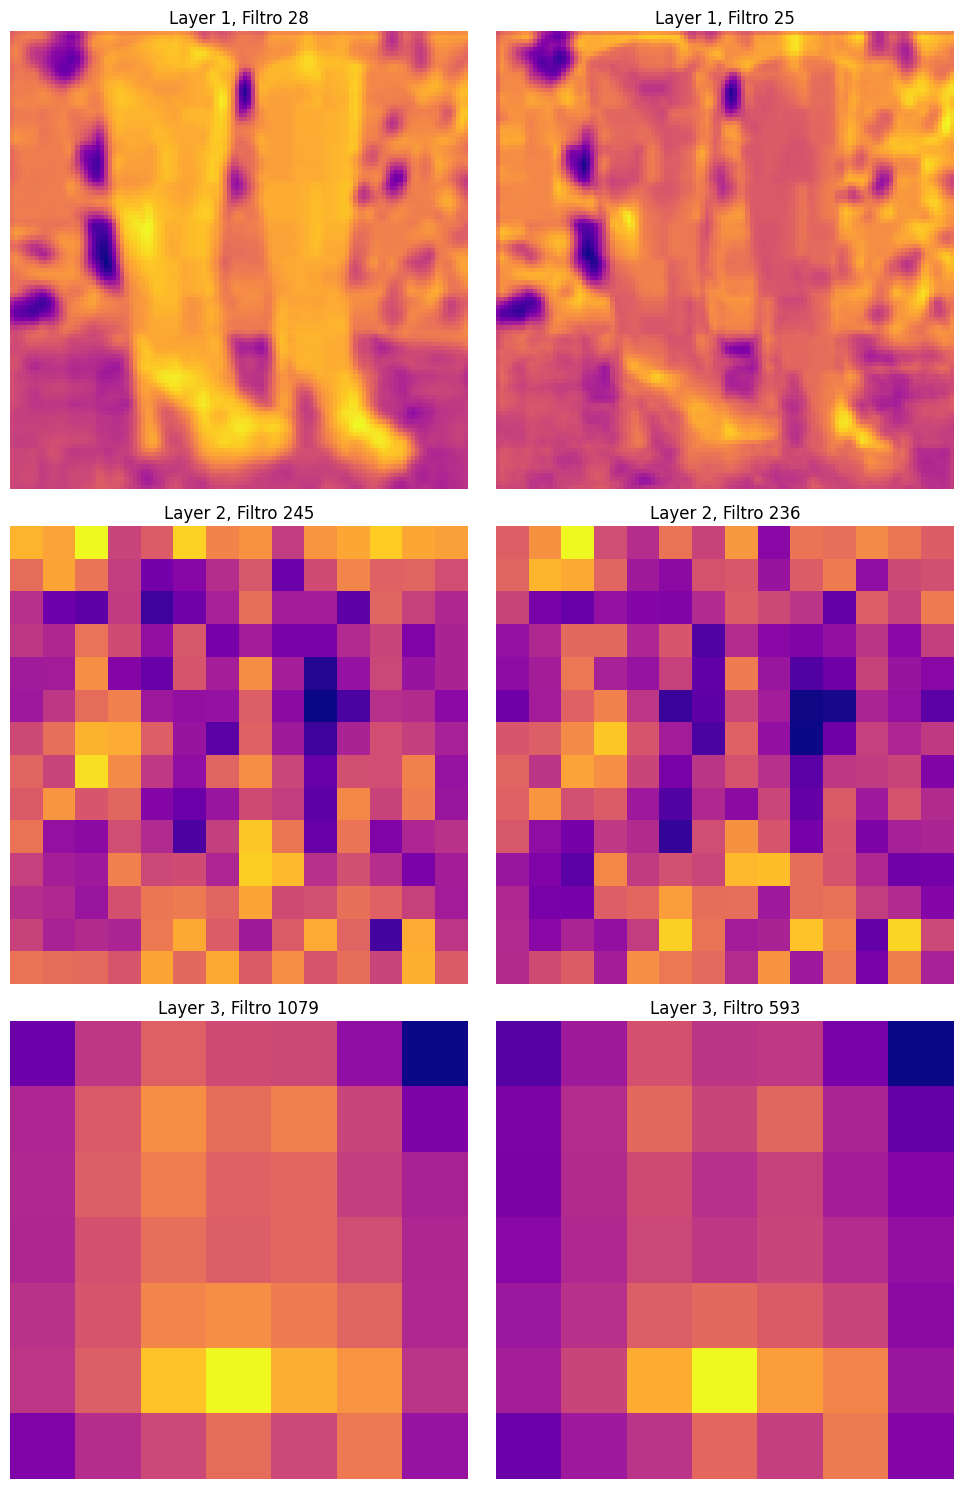

In [41]:
import torch
import matplotlib.pyplot as plt

# Funzione per registrare un hook e catturare le feature map
feature_maps = {}

def hook_fn(module, input, output):
    feature_maps[module] = output

# Identifica i layer convoluzionali della rete
conv_layers = [layer for layer in model.modules() if isinstance(layer, torch.nn.Conv2d)]

# Scegli il primo, un layer intermedio e l'ultimo
layers_to_visualize = [conv_layers[0], conv_layers[len(conv_layers)//2], conv_layers[-1]]

# Registra i forward hook solo sui layer selezionati
for layer in layers_to_visualize:
    layer.register_forward_hook(hook_fn)

# Passa un'immagine attraverso il modello
images, _ = next(iter(train_loader))  # Prendi un batch dal DataLoader
image = images[0].unsqueeze(0).to(device)  # Usa solo una immagine, aggiungi batch dimension
_ = model(image)  # Propagazione in avanti

# Visualizza 2 feature map più significative per ogni layer selezionato
fig, axes = plt.subplots(3, 2, figsize=(10, 15))  # Griglia 3x2 per 6 immagini
for row, (layer, fmap) in enumerate(feature_maps.items()):
    fmap = fmap.squeeze(0).detach().cpu()  # Rimuovi dimensione batch e porta su CPU

    # Trova l'importanza delle feature map (somma totale dei valori di ogni filtro)
    importance = fmap.sum(dim=(1, 2))  # Somma i valori di ogni filtro
    top_indices = importance.argsort(descending=True)[:2]  # Indici delle 2 feature map più significative

    # Visualizza le 2 feature map più significative
    for col, idx in enumerate(top_indices):
        significant_fmap = fmap[idx]  # Seleziona la feature map
        # Normalizza individualmente per evitare problemi di valori "bianchi"
        significant_fmap = (significant_fmap - significant_fmap.min()) / (significant_fmap.max() - significant_fmap.min() + 1e-5)

        axes[row, col].imshow(significant_fmap, cmap='plasma')  # Usa colormap più contrastante
        axes[row, col].axis('off')
        axes[row, col].set_title(f'Layer {row+1}, Filtro {idx}')

plt.tight_layout()
plt.show()



